# Importing necessary libraries 

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [2]:
os.path.abspath('.') # gives current path

'/home/dwip.dalal/Openvivo/Text to image generation'

# Loading the dataset

In [3]:
dataset = os.path.abspath('.') + "/annotations/captions_train2014.json"
with open(dataset, 'r') as f:
    data = json.load(f) #loaded the annotations file in annotations 

In [4]:
data.keys()

dict_keys(['info', 'images', 'licenses', 'annotations'])

### Let's make a dictionary that stores images paths as key and captions as values

In [5]:
image_path_to_caption = collections.defaultdict(list)
for val in data['annotations']:
  caption = "<start> " + val['caption'] + " <end>"
  image_path =  os.path.abspath('.') + '/train2014/' + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [6]:
print(next(iter(image_path_to_caption.keys()))) #here we can see that the list of image path forms the key of image_path_To_caption

/home/dwip.dalal/Openvivo/Text to image generation/train2014/COCO_train2014_000000318556.jpg


In [7]:
len(list(image_path_to_caption.keys()))

82783

### defining training dataset

In [8]:
train_image_paths = list(image_path_to_caption.keys())
random.shuffle(train_image_paths)

In [9]:
train_captions = []
image_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  image_vector.extend([image_path]*len(caption_list))

In [10]:
print(image_vector[2])

/home/dwip.dalal/Openvivo/Text to image generation/train2014/COCO_train2014_000000405194.jpg


<start> a large green and white clock tower in the middle of a plaza <end>


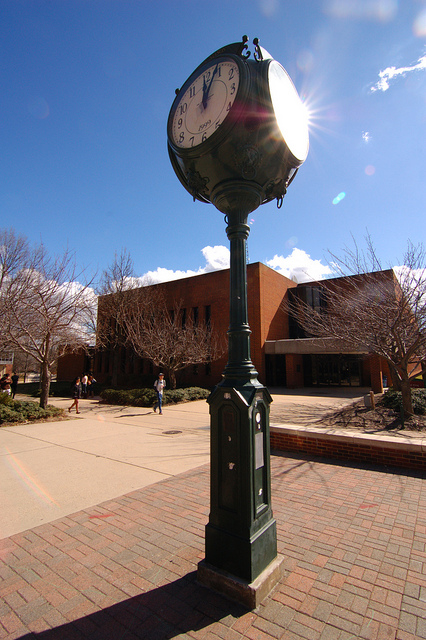

In [11]:
print(train_captions[0])
Image.open(image_vector[0])

# Tokenization

In [12]:
# train_captions

In [13]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

max_length = 50
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(max_tokens=vocabulary_size, output_sequence_length=max_length, standardize=standardize)
tokenizer.adapt(caption_dataset)
caption_vec = caption_dataset.map(lambda x: tokenizer(x))

2022-04-13 06:22:28.340770: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-13 06:22:30.663061: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30985 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2022-04-13 06:22:30.664470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22371 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2022-04-13 06:22:30.665648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:

In [14]:
word_to_index = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(mask_token="", vocabulary=tokenizer.get_vocabulary(), invert=True)

### Loading inceptionV2 and passing image through it so as to get abstract representation of the image 

In [15]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)  # since we shall use InceptionV3 
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [16]:
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet') # taking the inception model trained on image net
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

encode_train = sorted(set(image_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

2022-04-13 06:32:27.517774: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


# Splitting the dataset

In [17]:
img_to_caption_vec = collections.defaultdict(list)
for img, cap in zip(image_vector, caption_vec):
  img_to_caption_vec[img].append(cap)

img_keys = list(img_to_caption_vec.keys())
random.shuffle(img_keys)

image_name_train_keys, image_name_val_keys = img_keys[:int(len(img_keys)*0.8)], img_keys[int(len(img_keys)*0.8):]

image_name_train = []
caption_train = []

for imgt in image_name_train_keys:
  capt_len = len(img_to_caption_vec[imgt])
  image_name_train.extend([imgt] * capt_len)
  caption_train.extend(img_to_caption_vec[imgt])
  

image_name_val = []
cap_val = []
for imgv in image_name_val_keys:
  capv_len = len(img_to_caption_vec[imgv])
  image_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_caption_vec[imgv])

In [18]:
print(imgt)

/home/dwip.dalal/Openvivo/Text to image generation/train2014/COCO_train2014_000000408333.jpg


In [19]:
caption_train[3]

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([   3,    2,  107,   49,    2, 1240,   35,  117,   10,   20,  289,
        206,    2,  169,    8,    7,  170,    4,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])>

In [20]:
len(image_name_train), len(caption_train), len(image_name_val), len(cap_val)

(331294, 331294, 82819, 82819)

In [21]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(image_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
features_shape = 2048
attention_features_shape = 64

In [22]:
# Load the numpy files
def map_func(image_name, cap):
  img_tensor = np.load(image_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [23]:
len(image_name_train)

331294

In [24]:
caption_train[3]

<tf.Tensor: shape=(50,), dtype=int64, numpy=
array([   3,    2,  107,   49,    2, 1240,   35,  117,   10,   20,  289,
        206,    2,  169,    8,    7,  170,    4,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])>

In [25]:
dataset = tf.data.Dataset.from_tensor_slices((image_name_train, caption_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Model Architecture

In [26]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):  
    hidden_with_time_axis = tf.expand_dims(hidden, 1)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))
    score = self.V(attention_hidden_layer)
    attention_weights = tf.nn.softmax(score, axis=1)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [27]:
class CNN(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [28]:
class RNN(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN, self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units, return_sequences=True, return_state=True, recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)
    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [29]:
encoder = CNN(embedding_dim)
decoder = RNN(embedding_dim, units, tokenizer.vocabulary_size())

In [30]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [31]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder, decoder=decoder, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [32]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [33]:
loss_plot = []

In [34]:
@tf.function
def train_step(img_tensor, target):
  print(target)
  loss = 0
  hidden = decoder.reset_state(batch_size=target.shape[0])
  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(dec_input, features, hidden)
          loss += loss_function(target[:, i], predictions)
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))
  trainable_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [35]:
batch, (img_tensor, target) = next(iter(enumerate(dataset)))
print(target)
print(index_to_word(i) for i in target[0])

tf.Tensor(
[[   3   43  164 ...    0    0    0]
 [   3    2   27 ...    0    0    0]
 [   3    7 2489 ...    0    0    0]
 ...
 [   3    2  644 ...    0    0    0]
 [   3    2  470 ...    0    0    0]
 [   3    2   12 ...    0    0    0]], shape=(64, 50), dtype=int64)
<generator object <genexpr> at 0x7fe67b4ff200>


In [36]:
EPOCHS = 25

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
#         print(img_tensor.shape, target.shape)
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Tensor("target:0", shape=(64, 50), dtype=int64)
Tensor("target:0", shape=(64, 50), dtype=int64)


Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.2/targets/x86_64-linux/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


Epoch 1 Batch 0 Loss 1.9338
Epoch 1 Batch 100 Loss 1.1444
Epoch 1 Batch 200 Loss 0.9918
Epoch 1 Batch 300 Loss 0.8882
Epoch 1 Batch 400 Loss 0.8057
Epoch 1 Batch 500 Loss 0.8316
Epoch 1 Batch 600 Loss 0.7389
Epoch 1 Batch 700 Loss 0.7870
Epoch 1 Batch 800 Loss 0.7553
Epoch 1 Batch 900 Loss 0.7506
Epoch 1 Batch 1000 Loss 0.7112
Epoch 1 Batch 1100 Loss 0.7401
Epoch 1 Batch 1200 Loss 0.6491
Epoch 1 Batch 1300 Loss 0.7251
Epoch 1 Batch 1400 Loss 0.7281
Epoch 1 Batch 1500 Loss 0.6851
Epoch 1 Batch 1600 Loss 0.7356
Epoch 1 Batch 1700 Loss 0.7174
Epoch 1 Batch 1800 Loss 0.7085
Epoch 1 Batch 1900 Loss 0.6659
Epoch 1 Batch 2000 Loss 0.7217
Epoch 1 Batch 2100 Loss 0.6971
Epoch 1 Batch 2200 Loss 0.7351
Epoch 1 Batch 2300 Loss 0.7150
Epoch 1 Batch 2400 Loss 0.6856
Epoch 1 Batch 2500 Loss 0.7420
Epoch 1 Batch 2600 Loss 0.6736
Epoch 1 Batch 2700 Loss 0.6390
Epoch 1 Batch 2800 Loss 0.6756
Epoch 1 Batch 2900 Loss 0.6565
Epoch 1 Batch 3000 Loss 0.5836
Epoch 1 Batch 3100 Loss 0.6480
Epoch 1 Batch 3200 L

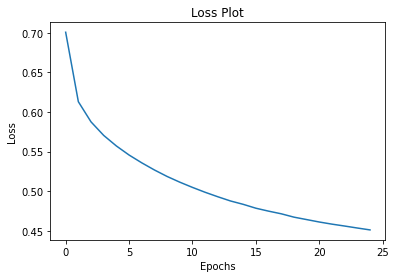

In [37]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [38]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [39]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

['a', 'vase', 'that', 'has', 'a', 'cluster', 'of', 'pink', 'and', 'yellow', 'flowers.', '<end>']
Real Caption:  a bunch of flowers with red leaves. 
Prediction Caption: a vase that has a cluster of pink and yellow flowers. 


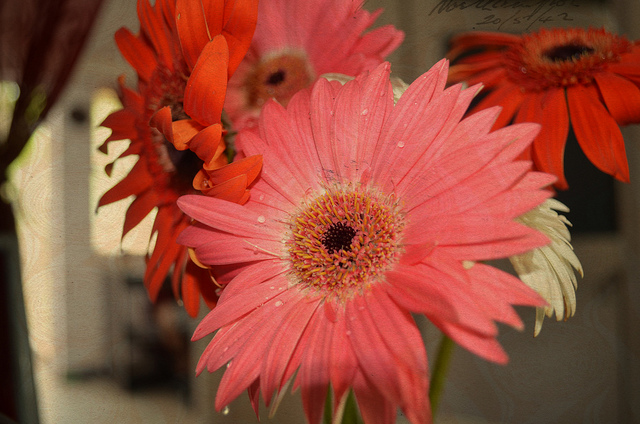

In [55]:
# captions on the validation set
rid = np.random.randint(0, len(image_name_val))
image = image_name_val[rid]
real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)
print(result)
print('Real Caption:', real_caption[7:-5])
print('Prediction Caption:', ' '.join(result)[:-5])
Image.open(image)